# Mode Connectivity of Neural Networks (Part 2)

<br>

## Introduction

In this part of the project we will implement a different path algorithm based on a property of a well trained network - **dropout-stability**. Notably enough, the approach is constructive, i.e., we get a closed form expression for a piecewise linear path between minima found by SGD with *no optimization required*.

<br>

In [48]:
# importing all packages necessary

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from copy import deepcopy

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 14})

### SGD Solutions for Large Network Width are Dropout Stable

In this section, we will train a couple of two-layer networks with SGD to see that when the number of neurons $N$ is sufficiently large the loss of full network and the network with half of connections (suitably rescaled) are close through the whole training procedure.

#### Setup

In order to be aligned with theory we consider a slightly different version of the network and training algorithm. In particular, the two-layer mean-field network

$$
y_{{\theta}_N}({x}) = \frac{1}{N} \sum_{i=1}^N a_i \sigma({w}_i^T {x} + b_i),
$$

where $x \in \mathbb{R}^d$ is network input, $\theta_N = \{(a_i \in \mathbb{R}, w_i \in \mathbb{R}^d, b_i \in \mathbb{R})\}_{i=1}^N \in \mathbb{R}^{d+2}$ are network parameters and $\sigma: \mathbb{R} \rightarrow \mathbb{R}$ stands for the activation function. The initial values for parameters are drawn from normal distribution with variance independent from $N$, e.g., from normal distribution with unit variance. This ensures that the network output concentrates to the mean value as $N \rightarrow \infty$.

**Remark.** Notice $\frac{1}{N}$ factor in network definition.

For optimization algorithm we consider SGD with rescaled by a factor of $N$ gradient (in order to make theory work):

$$
\theta^{k+1}_N = \theta^{k}_N - \alpha \nabla_{\theta}L(y^k,y_{{\theta_N^k}}({x}^k)) \cdot N,
$$

where $L$ defines a loss function and $(x^k, y^k) \sim \mathcal{D}$ is current training example and $\mathcal{D}$ is data distribution.

#### Dropout stability

First we define the dropout network with corresponding dropout pattern $A \in \{1,\cdots,N\}$

$$
y_{{\theta}_N, A}(x) = \frac{1}{|A|} \sum_{i\in A} a_i \sigma({w}_i^T {x} + b_i),
$$

where $|A|$ stands for cardinality of set $A$.

The set of network parameters $\theta_N$ is called dropout stable if there exists a dropout pattern $A$ such that

$$
|\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta_{N},A}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta_{N}}}({x}))| \leq \varepsilon_D,
$$

for some small value of $\varepsilon_D$.

Without loss of generality we can assume that the dropout pattern is always $A = \{1,\cdots,N/2\}$ and define the shorthand notation

$$
y_{{\theta}_N, A}(x) = y_{{\theta}_{N/2}}(x).
$$

It can be shown that during SGD

$$
|\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N},N/2}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N}}}({x}))| \rightarrow 0
$$

for squared risk, i.e., $L(y,y') = (y-y')^2$ as long as $N \rightarrow \infty$ and $\alpha \rightarrow 0$. In particular, if $K$ is total number of iterations then $K\alpha = \textrm{const}$. For example, we can pick $\alpha = C_1/N$ and $K = C_2N$ for some constants $C_1$ and $C_2$.

**Remark:** Aforementioned relation between number of iterations, learning rate and width of network is crucial. It should be preserved later when we train two networks of different sizes.

In a nutshell, according to aforementioned we expect the difference between the *dropout* network and full one to vanish as width $N$ grows larger with step size $\alpha \rightarrow 0$.

#### Multiple outputs 

We defined dropout network for the case when the number of outputs $M=1$. Now consider $M>1$. In this case, we have

$$
y^m_{{\theta}_N}({x}) = \frac{1}{N} \sum_{i=1}^N a^m_i \sigma({w}_i^T {x} + b_i), \quad m \in \{1,\cdots,M\},
$$

thus, the dropout network will correspond to dropping the half of $a_i^m$ for current $m$ and rescaling remaining ones, i.e.,

$$
y^m_{{\theta}_{N/2}}(x) = \frac{2}{N} \sum_{i=1}^{N/2} a^m_i \sigma({w}_i^T {x} + b_i).
$$

#### MNIST Dataset

First we download the dataset and normalize each image for optimization stability. ``train_loader`` loader and ``test_loader`` are iterators for corresponding parts of the dataset.

In [22]:
# convert image to tensor for PyTorch, and normalize with mean and std for stability
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

# downloading training and test parts of MNIST dataset
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)

# get train and test samplers with B=100 for train and B=1000 for test
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000, shuffle=False)

#### Network Definition

Define two layer network described above with $N$ neurons in hidden layer and 10 outputs for MNIST classification task. For activation use Rectified Linear Unit (ReLU). Network gets as an input flattened to a vector of size $28\times28$ image.

**Remark:** ``nn.Linear`` initializes ``.weight from`` distribution with variance that vanishes with $N \rightarrow \infty$. Thus, to define network defined above you need to reinit the weights $w$ and $a$ from distribution with constant variance. **Use the values provided for your group.** **Keep init for ``.bias`` of the first layer as is.**


To disable bias in last linear layer, i.e., to get only $a$'s use flag: ``bias=False`` in ``nn.Linear(...)``. Weight for each ``nn.Linear`` object can be accessed via ``object.weight``. Reinit of weight should be done in init method of class.

**Do not forget ot rescale output of network by $\frac{1}{N}$**.

In [23]:
class FCN(nn.Module):
    
    def __init__(self, N):
        super(FCN, self).__init__()
        self.N = N
        
        self.fc1 = nn.Linear(28 * 28, N)
        self.fc1.weight.data.normal_(0.0, 1.4) # w
        
        self.fc2 = nn.Linear(N, 10, bias=False)
        self.fc2.weight.data.normal_(1.0, 0.4) # a
        
        self.act = nn.ReLU()
        
        # => define layers and reinit a, w using layer.weight.data.normal_() or other dist depending on your group
        
    def forward(self, x):
        # => Implement a forward pass
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x/self.N

#### Training with different $N$'s

Below we provide a function to compute test loss and test classification error to estimate $\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N},N/2}}({x}))$ and $\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta^k_{N}}}({x}))$ during training, i.e., metrics for full and dropout network. **You can modify the function to print additional info if you need.**

In [26]:
def test(model, test_loader):
    model.eval()
    test_loss = 0.
    correct = 0.
    
    with torch.no_grad():
        for data, target in test_loader:
            data = data.view(-1, 28 * 28)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('Test loss: ', test_loss)
    print('Accuracy: ', 100* correct / len(test_loader.dataset), '%')
    
    return test_loss, 1. - 1. * correct / len(test_loader.dataset)

Implement a function which takes full network and returns its dropout version, i.e., where $\hat{a}_j^k = 0$ for $j \geq N/2,\ k \in \{1,\cdots,10\}$ and  $\hat{a}_j^k = 2 a_j^k$ for $j < N/2,\ k \in \{1,\cdots,10\}$. In other words, we set half of the final layer weights to zero and rescale the remaining ones by factor of two.

In [27]:
def get_dropout_network(model):
    model_dropout = deepcopy(model)
    # => Drop and rescale a's 
    
    old_params = {}
    for name, params in model_dropout.named_parameters():
        old_params[name] = params.clone()
    
    N = old_params['fc2.weight'].shape[1]
    old_params['fc2.weight'][:int(N/2)] *= 2.
    old_params['fc2.weight'][int(N/2):] = 0.
    
    for name, params in model_dropout.named_parameters():
        params.data.copy_(old_params[name])
    
    return model_dropout

Now you need to train two networks with sizes $N=N_1$ and $N=N_2$. **Use $N_1$ and $N_2$ values provided for your group.**

As it was mentioned before pick learning rate $\alpha$ and total number of iterations $K$ such that $\alpha=C_1/N$ and $K = C_2 N$. In particular, if for $N=800$ the value of learning rate is $\alpha$ and number of iterations is equal to $K$, then for $N=3200$ the learning rate should be set to $\alpha / 4$ and number of iterations to $4K$.

Through training we would like to track the **test loss** and **test classification error** for both full network and dropout network. To evaluate the metrics use ``test(...)`` function defined above. Save corresponding values to plot later.
Define a uniform grid in **log** scale w.r.t. the total number of iterations and evaluate metrics at each point $k$ of grid.

**Remark:** Do not forget to rescale gradients by a factor of $N$ during training in accrodance with theory mentioned before.

Implement a function below which trains a network of size $N$ and returns 

$$\text{(list of test losses and errors of full network, list of test losses and errors of dropout network, final_model)}$$

The final full model should achieve reasonable accuracy, i.e. $\approx 97-98$%.

**Note:** ``population_`` prefix stands for loss.

In [28]:
def train(model, train_loader, optimizer, epoch, lr, N):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader): # sample subset of dataset - (x,y)
        # input
        data = data.view(-1, 28 * 28) # reshape 2d image to vector of size 28x28
        
        # => Implement a computation of gradient for current batch of data

        optimizer.zero_grad()
        output = model(data)
        L = F.cross_entropy(output, target)
        L.backward()
        with torch.no_grad():
            for p in model.parameters():
#                 new_val = update_function(p, p.grad, loss, other_params)
                new_val = p - p.grad*lr*N
                p.copy_(new_val)
        
        # => Implement progress tracker
        running_loss += L.item()
        if batch_idx % 200 == 0:
            print("Loss at step {} is {}".format(batch_idx, running_loss/200))
            running_loss = 0.0

In [62]:
## version 1
# train the model, do dropout, calculate loss/error
def get_curves_and_model_v1(N):
    population_curve, error_curve = [], [] # list to store test losses and errors of full network
    population_curve_dropout, error_curve_dropout = [], [] # list to store test losses and errors of dropout network

    # => Implementation
    
    C1 = 10. # such that learning rate is 0.1 for N=100
    C2 = 0.15 # such that number of iterations K is 15
    lr = C1 / N
    n_epoch = int(C2 * N)
    
    model = FCN(N)
    optimizer = optim.SGD(model.parameters(), lr=lr) 
    # ===> Implement training
    
    # ===> Train + test step with optional StepLR call
    for epoch in range(1, n_epoch + 1):
        print('Epoch ', epoch)
        train(model, train_loader, optimizer, epoch, lr, N)
        
        l1, e1 = test(model, test_loader) # l1=average loss on test, e1=average 1-accuracy on test
        population_curve.append(l1)
        error_curve.append(e1)

        dropout_model = get_dropout_network(model)
        l2, e2 = test(dropout_model, test_loader)
        population_curve_dropout.append(l2)
        error_curve_dropout.append(e2)
            
    return population_curve, error_curve, population_curve_dropout, error_curve_dropout, model

In [63]:
## version 2
# do dropout, train both models independently, calculate loss/error
def get_curves_and_model_v2(N):
    population_curve, error_curve = [], [] # list to store test losses and errors of full network
    population_curve_dropout, error_curve_dropout = [], [] # list to store test losses and errors of dropout network

    C1 = 10
    C2 = 0.15
    lr = C1 / N
    n_epoch = int(C2 * N)
    
    # => Implementation
    print("full")
    model=FCN(N)
    model_dropout=get_dropout_network(model)

    optimizer = optim.SGD(model.parameters(), lr=lr)
    for epoch in range(1, n_epoch + 1):
        print('Epoch ', epoch)
        train(model, train_loader, optimizer, epoch,lr,N)
        population_curve_i, error_curve_i=test(model, test_loader)
        population_curve.append(population_curve_i)
        error_curve.append(error_curve_i)
    print("dropout")
    
    optimizer = optim.SGD(model_dropout.parameters(), lr=lr)
    for epoch in range(1, n_epoch + 1):
        print('Epoch ', epoch)
        train(model_dropout, train_loader, optimizer, epoch,lr,N)
        population_curve_i, error_curve_i=test(model_dropout, test_loader)
        population_curve_dropout.append(population_curve_i)
        error_curve_dropout.append(error_curve_i)
    
    return population_curve, error_curve, population_curve_dropout, error_curve_dropout, model_dropout

Get curves and network for $N=N_1$.

In [64]:
N_1 = 100

population_curve_N_1, error_curve_N_1, population_curve_dropout_N_1, error_curve_dropout_N_1, model_N_1 = get_curves_and_model_v2(N=N_1)

full
Epoch  1
Loss at step 0 is 0.01238914132118225
Loss at step 200 is 0.5394510645419359
Loss at step 400 is 0.2987909301370382
Test loss:  0.2164051773071289
Accuracy:  93.45 %
Epoch  2
Loss at step 0 is 0.0012201584875583648
Loss at step 200 is 0.1994081643037498
Loss at step 400 is 0.1811659160722047
Test loss:  0.15839411392211913
Accuracy:  95.14 %
Epoch  3
Loss at step 0 is 0.0006417760998010635
Loss at step 200 is 0.14401688368991017
Loss at step 400 is 0.1318406061269343
Test loss:  0.1413803867340088
Accuracy:  95.57 %
Epoch  4
Loss at step 0 is 0.0007010194659233094
Loss at step 200 is 0.10905209500342608
Loss at step 400 is 0.12813479240052403
Test loss:  0.1263686149597168
Accuracy:  96.06 %
Epoch  5
Loss at step 0 is 0.0003979696333408356
Loss at step 200 is 0.09635888841934502
Loss at step 400 is 0.09475412325933576
Test loss:  0.11668268432617188
Accuracy:  96.43 %
Epoch  6
Loss at step 0 is 0.00024540353566408155
Loss at step 200 is 0.08234860130120068
Loss at step 40

Plot two figures: 

1) test risks of full and dropout network during training

2) test errors of full and dropout network during training

Use log scale for $x$-axis (iterations).

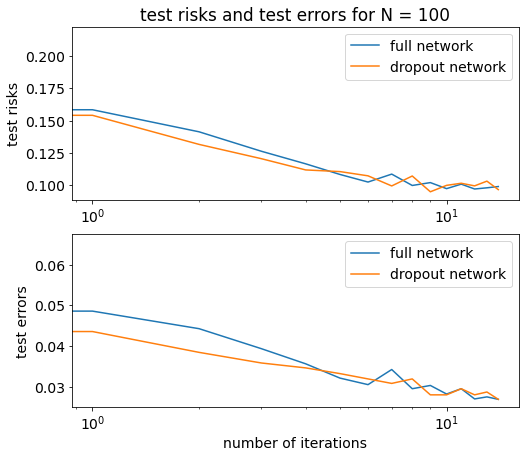

In [79]:
# => Plot 
fig, ax = plt.subplots(2, 1, figsize = (8,7))

iters = np.arange(len(population_curve_N_1))
ax[0].plot(iters, population_curve_N_1, label = 'full network')
ax[0].plot(iters, population_curve_dropout_N_1, label = 'dropout network')
ax[0].legend()
ax[0].set_title('test risks and test errors for N = {}'.format(N_1))
ax[0].set_ylabel('test risks')
ax[0].set_xscale('log')

ax[1].plot(iters, error_curve_N_1, label = 'full network') # , ls='dashed'
ax[1].plot(iters, error_curve_dropout_N_1, label = 'dropout network')
ax[1].legend()
ax[1].set_xlabel('number of iterations')
ax[1].set_ylabel('test errors')
ax[1].set_xscale('log')
# plt.savefig('../figures/modeconnectivity_2_riskerror_v2_N1.pdf', bbox_inches='tight')
plt.show()

Get curves and network for $N=N_2$.

In [66]:
N_2 = 200

population_curve_N_2, error_curve_N_2, population_curve_dropout_N_2, error_curve_dropout_N_2, model_N_2 = get_curves_and_model_v2(N=N_2)

full
Epoch  1
Loss at step 0 is 0.013274848461151123
Loss at step 200 is 0.5022043719887733
Loss at step 400 is 0.3038073101639748
Test loss:  0.21429768524169923
Accuracy:  93.44 %
Epoch  2
Loss at step 0 is 0.0009580226987600327
Loss at step 200 is 0.20581916574388742
Loss at step 400 is 0.19372417537495493
Test loss:  0.16482185020446777
Accuracy:  94.81 %
Epoch  3
Loss at step 0 is 0.0005937597900629043
Loss at step 200 is 0.15492463774979115
Loss at step 400 is 0.1432431729696691
Test loss:  0.1388160919189453
Accuracy:  95.68 %
Epoch  4
Loss at step 0 is 0.0006682400405406952
Loss at step 200 is 0.12488292616792024
Loss at step 400 is 0.12321930628269911
Test loss:  0.12243174972534179
Accuracy:  96.21 %
Epoch  5
Loss at step 0 is 0.0004920653253793716
Loss at step 200 is 0.10381354363635183
Loss at step 400 is 0.1058941406197846
Test loss:  0.11435168952941895
Accuracy:  96.45 %
Epoch  6
Loss at step 0 is 0.000242861844599247
Loss at step 200 is 0.09118092288263142
Loss at step 

Plot the same figures but for $N=N_2$. **Did full network and dropout network become closer?**

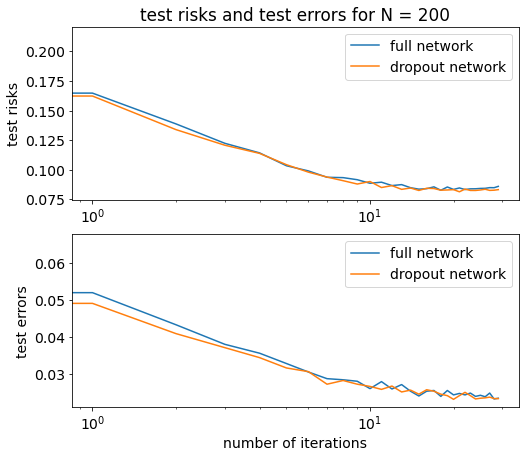

In [78]:
# => Plot 
fig, ax = plt.subplots(2, 1, figsize = (8,7))

iters = np.arange(len(population_curve_N_2))
ax[0].plot(iters, population_curve_N_2, label = 'full network')
ax[0].plot(iters, population_curve_dropout_N_2, label = 'dropout network')
ax[0].legend()
ax[0].set_title('test risks and test errors for N = {}'.format(N_2))
ax[0].set_ylabel('test risks')
ax[0].set_xscale('log')

ax[1].plot(iters, error_curve_N_2, label = 'full network') #, ls='dashed'
ax[1].plot(iters, error_curve_dropout_N_2, label = 'dropout network')
ax[1].legend()
ax[1].set_xlabel('number of iterations')
ax[1].set_ylabel('test errors')
ax[1].set_xscale('log')
# plt.savefig('../figures/modeconnectivity_2_riskerror_v2_N2.pdf', bbox_inches='tight')
plt.show()

### Constructing a path

As it was mentioned previously in introduction dropout stability of solution allows to obtain a closed form of piecewise linear path which connects two solutions. Before going straight to the point we need to train another network with $N=N_2$ neurons (for second solution).

In [68]:
population_curve_N_2_2, error_curve_N_2_2, population_curve_dropout_N_2_2, error_curve_dropout_N_2_2, model_N_2_2 = get_curves_and_model_v2(N=N_2)

full
Epoch  1
Loss at step 0 is 0.014078794717788697
Loss at step 200 is 0.5257258789986372
Loss at step 400 is 0.3144761744514108
Test loss:  0.22153130264282225
Accuracy:  93.65 %
Epoch  2
Loss at step 0 is 0.0014536109566688537
Loss at step 200 is 0.21316860053688289
Loss at step 400 is 0.2088534826412797
Test loss:  0.16763545532226562
Accuracy:  95.25 %
Epoch  3
Loss at step 0 is 0.0007761530578136444
Loss at step 200 is 0.16361423121765256
Loss at step 400 is 0.15285036457702517
Test loss:  0.14497510147094728
Accuracy:  95.91 %
Epoch  4
Loss at step 0 is 0.00028135623782873156
Loss at step 200 is 0.12875264547765256
Loss at step 400 is 0.12623758437111973
Test loss:  0.12550502319335938
Accuracy:  96.32 %
Epoch  5
Loss at step 0 is 0.0003604758158326149
Loss at step 200 is 0.10881534147076309
Loss at step 400 is 0.10617774656973779
Test loss:  0.1135434497833252
Accuracy:  96.54 %
Epoch  6
Loss at step 0 is 0.0006462559103965759
Loss at step 200 is 0.09727835558354854
Loss at st

In [69]:
model_1 = deepcopy(model_N_2)
model_2 = deepcopy(model_N_2_2)

#### Piecewise Linear Path

Assume that we have two dropout stable sets of parameters $\theta$ and $\theta'$, i.e.,

$$
|\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta,N/2}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta}}({x}))| \leq \varepsilon, \quad |\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta',N/2}}({x})) - \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta'}}({x}))| \leq \varepsilon
$$

For some loss $L$ which is convex in parameters of the last layer, i.e., $a$'s.

Now consider the case where there is no bias in the first layer, or simply add $1$ to the feature vector $x$ and increase dimension of $w$ by 1. **Provide a proof for lemma below**.

**Lemma.** Consider a two-layer mean-field network with one output and some activation $\sigma$. Let $\theta=((a_1, w_1), (a_2, w_2), \ldots, (a_N, w_N))$ and $\theta'=((a_1', w_1'), (a_2', w_2'), \ldots, (a_N', w_N'))$. Assume that $N$ is even. Consider the piecewise linear path in parameter space that connects $\theta$ to $\theta'$ via the following intermediate points:

\begin{equation}
\begin{split}
\theta_1&=((2a_1, w_1), (2a_2, w_2), \ldots, (2a_{N/2}, w_{N/2}), (0, w_{N/2+1}), (0, w_{N/2+2}), \ldots, (0, w_N)),\\
\theta_2&=((2a_1, w_1), (2a_2, w_2), \ldots, (2a_{N/2}, w_{N/2}), (0, w_{1}'), (0, w_{2}'), \ldots, (0, w_{N/2}')),\\
\theta_3&=((0, w_1), (0, w_2), \ldots, (0, w_{N/2}), (2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}')),\\
\theta_4&=((0, w_1'), (0,w_2'), \ldots, (0,w_{N/2}'), (2a_1',w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}')),\\
\theta_5&=((2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}'), (0, w_1'), (0, w_2'), \ldots, (0, w_{N/2}')),\\
\theta_6&=((2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}'), (0, w_{N/2+1}'), (0, w_{N/2+2}'), \ldots, (0, w_N')).
\end{split}
\end{equation}

The loss along this path is upper bounded by $\max(\mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta}}({x})), \mathbb{E}_{(x,y) \sim \mathcal{D}} L(y,y_{{\theta'}}({x})))+\varepsilon$. 

**Remark:** The path consists of linear segments, i.e., 

$$
\theta(t) = (1-t)\theta_{k-1} + t\theta_{k}, \quad t \in [0,1].
$$

**Proof of Lemma:** The proof of the lemma is given by Alexander Shevchenko and Marco Mondelli in https://arxiv.org/abs/1912.10095 (2020). We do not copy and paste the proof here, but want to motivate the general idea of it. Starting from the fact that $\theta$ is $\varepsilon$-dropout stable, the proof is split into each of the seven segments. For the majority of segments the loss does not change along the path, which can be seen easily and was already noticed by us, as for the one connecting $\theta_1$ to $\theta_2$. For the other segments it is used that the loss is convex in the weights of the last layer and therefore upper bounded by the loss plus an $\varepsilon$. 

#### Implementation

In this task you would need to implement a path defined above and evaluate the test loss for 10 points in each segment and then plot the resulting curve of loss vs position on path.

**Note:** The path for multiple outputs looks essentially the same. The only difference is that you need to do the aforementioned for each class $m$ weight $a_i^m$.

Below we provide a couple of helper functions.

**get_partition** Partitions each layer parameters on two portions - top half and bottom half (which is exactly needed for the path above). In particular, last layer parameters, i.e., $a$'s, are ensembled into $A_1$ which is the top half and $B_1$ which is the bottom half, $A_2, B_2$ are corresponding parts of the first layer weights $w$ and $a_2,b_2$ is the first layer bias partition.


**insert_params** Inserts provided set of parameters into a dummy network.

In [70]:
h = int(N_2 / 2)

def get_partition(model):
    W, bias, a_ = deepcopy(list(model.parameters()))
    W, bias, a_ = W.data, bias.data, a_.data
    A_1, B_1, A_2, B_2, a_2, b_2 = a_[:,:h], a_[:,h:], W[:h,:], W[h:,:], bias[:h], bias[h:]
    return A_1, B_1, A_2, B_2, a_2, b_2

def insert_params(model, A_1, B_1, A_2, B_2, a_2, b_2):
    for i, param in enumerate(model.parameters()):
        if i == 0:
            param.data[:h,:] = A_2
            param.data[h:,:] = B_2
        if i == 1:
            param.data[:h] = a_2
            param.data[h:] = b_2
        if i == 2:
            param.data[:,:h] = A_1
            param.data[:,h:] = B_1
    return model

Partition parameters for later usage. Parameters of second network, i.e., $\theta'$ have additional underscore after the name.

In [71]:
A_1, B_1, A_2, B_2, a_2, b_2 = get_partition(model_1)
A_1_, B_1_, A_2_, B_2_, a_2_, b_2_ = get_partition(model_2)

Get a dummy model.

In [72]:
model = FCN(N=N_2)

Below we provide an example for the first line segement between $\theta$ and $\theta_1$. **Implement** the remaining pieces. All segments should be functions with ``_i`` postfix done in the same fashion as ``segment_1``.

In [73]:
# segment_1 connects 𝜃 to 𝜃_1
# segment_i connects 𝜃_{i-1} to 𝜃_i, i=2,3,4,5,6
# segment_7 connects 𝜃_6 to 𝜃'
segment_1 = lambda t: insert_params(model, (1-t)*A_1 + 2*t*A_1, (1-t)*B_1, A_2, B_2, a_2, b_2)

# => Implement remaining 6 segments
segment_2 = lambda t: insert_params(model, 2*A_1, 0, A_2, (1-t)*B_2 + t*A_2_, a_2, b_2)
segment_3 = lambda t: insert_params(model, 2*(1-t)*A_1, 2*t*A_1_, A_2, A_2_, a_2, b_2)
segment_4 = lambda t: insert_params(model, 0, 2*A_1_, (1-t)*A_2 + t*A_2_, A_2_, a_2, b_2)
segment_5 = lambda t: insert_params(model, 2*t*A_1_, 2*(1-t)*A_1_, A_2_, A_2_, a_2, b_2)
segment_6 = lambda t: insert_params(model, 2*A_1_, 0, A_2_, (1-t)*A_2_ + t*B_2_, a_2, b_2)
segment_7 = lambda t: insert_params(model, 2*(1-t)*A_1_ + t*A_1_, t*B_1_, A_2_, B_2_, a_2, b_2) # TODO a_2, b_2 --> a_2_ and b_2_?

\begin{equation}
\begin{split}
\theta&=((a_1, w_1), (a_2, w_2), \ldots, (a_N, w_N)),\\
\theta_1&=((2a_1, w_1), (2a_2, w_2), \ldots, (2a_{N/2}, w_{N/2}), (0, w_{N/2+1}), (0, w_{N/2+2}), \ldots, (0, w_N)),\\
\theta_2&=((2a_1, w_1), (2a_2, w_2), \ldots, (2a_{N/2}, w_{N/2}), (0, w_{1}'), (0, w_{2}'), \ldots, (0, w_{N/2}')),\\
\theta_3&=((0, w_1), (0, w_2), \ldots, (0, w_{N/2}), (2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}')),\\
\theta_4&=((0, w_1'), (0,w_2'), \ldots, (0,w_{N/2}'), (2a_1',w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}')),\\
\theta_5&=((2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}'), (0, w_1'), (0, w_2'), \ldots, (0, w_{N/2}')),\\
\theta_6&=((2a_1', w_1'), (2a_2', w_2'), \ldots, (2a_{N/2}', w_{N/2}'), (0, w_{N/2+1}'), (0, w_{N/2+2}'), \ldots, (0, w_N')),\\
\theta'&=((a_1', w_1'), (a_2', w_2'), \ldots, (a_N', w_N'))
\end{split}
\end{equation}

**Remark:** The path consists of linear segments, i.e., 

$$
\theta(t) = (1-t)\theta_{k-1} + t\theta_{k}, \quad t \in [0,1].
$$

In particular, last layer parameters, i.e., $a$'s, are ensembled into $A_1$ which is the top half and $B_1$ which is the bottom half, $A_2, B_2$ are corresponding parts of the first layer weights $w$ and $a_2,b_2$ is the first layer bias partition.

Getting test loss for 10 points in each linear segment for plot.

In [74]:
from tqdm.notebook import trange

loss = []
for i in trange(1,8):
    name = f'segment_{i}'
    line = globals()[name]
    
    for t in np.linspace(0,1,10):
        loss.append(test(line(t), test_loader)[0])

Test loss:  0.08330957412719726
Accuracy:  97.68 %
Test loss:  0.09172686958312988
Accuracy:  97.46 %
Test loss:  0.11538523750305175
Accuracy:  96.75 %
Test loss:  0.16085670127868654
Accuracy:  95.51 %
Test loss:  0.239721085357666
Accuracy:  93.5 %
Test loss:  0.36657055969238284
Accuracy:  90.87 %
Test loss:  0.5549421600341797
Accuracy:  87.57 %
Test loss:  0.8182309814453125
Accuracy:  82.95 %
Test loss:  1.1670739013671876
Accuracy:  78.01 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58 %
Test loss:  1.6095293090820313
Accuracy:  72.58

Implement linear interpolation between $\theta$ and $\theta'$ to compare. ``segment_linear`` should be implemented in the same fashion as previously ``segment_i``. Linear interpolation means

$$
\theta(t) = (1-t) \theta + t \theta', \quad t \in [0,1].
$$

In [75]:
from tqdm.notebook import trange, tqdm

# => Implement linear interpolation
segment_linear = lambda t: insert_params(model, (1-t)*A_1 + t*A_1_, (1-t)*B_1 + t*B_1_, (1-t)*A_2 + t*A_2_, (1-t)*B_2 + t*B_2_, (1-t)*a_2 + t*a_2_, (1-t)*b_2 + t*b_2_)

loss_linear = []
for t in tqdm(np.linspace(0,1,70)):
    loss_linear.append(test(segment_linear(t), test_loader)[0])

Test loss:  0.08330957412719726
Accuracy:  97.68 %
Test loss:  0.08260561771392823
Accuracy:  97.65 %
Test loss:  0.08235216026306152
Accuracy:  97.65 %
Test loss:  0.08255278663635254
Accuracy:  97.62 %
Test loss:  0.08326644706726075
Accuracy:  97.57 %
Test loss:  0.08453269481658936
Accuracy:  97.55 %
Test loss:  0.08636457653045654
Accuracy:  97.49 %
Test loss:  0.08884849300384522
Accuracy:  97.31 %
Test loss:  0.09207870216369629
Accuracy:  97.21 %
Test loss:  0.0961180274963379
Accuracy:  97.05 %
Test loss:  0.10112682800292969
Accuracy:  96.85 %
Test loss:  0.10727904815673828
Accuracy:  96.63 %
Test loss:  0.11469346084594727
Accuracy:  96.49 %
Test loss:  0.12348335418701172
Accuracy:  96.18 %
Test loss:  0.1338283866882324
Accuracy:  95.88 %
Test loss:  0.14598212661743165
Accuracy:  95.5 %
Test loss:  0.16011542739868165
Accuracy:  95.02 %
Test loss:  0.17637733840942382
Accuracy:  94.55 %
Test loss:  0.19483806228637696
Accuracy:  93.9 %
Test loss:  0.21555428161621093
Acc

Plot test risk on linear path and piece-wise linear which uses dropout stability. Use ``loss_linear`` and ``loss`` list for corresponding values. **Is more "intelligent" path better?**.

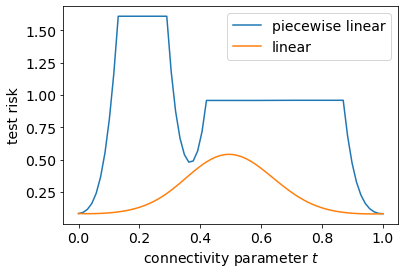

In [77]:
# => Plot risk on two paths
# => plot loss on paths
plt.figure() #figsize = (6,4)
times = np.linspace(0, 1, 70)
plt.plot(times, loss, label='piecewise linear')
plt.plot(times, loss_linear, label='linear')
plt.xlabel(r'connectivity parameter $t$')
plt.ylabel(r'test risk')
plt.legend()
# plt.savefig('../figures/modeconnectivity_2_risk_linear_v2.pdf', bbox_inches='tight')
plt.show()

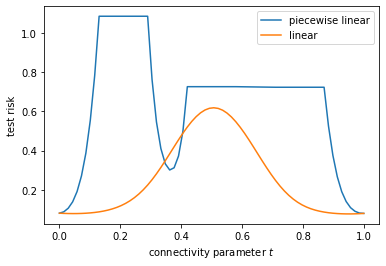

In [42]:
# test